# Evaluation notebook for `AlgebraicPL` Quadratic landscapes


In [1]:
import argparse
from argparse import Namespace
import warnings
import os
import tqdm as tqdm
import numpy as np
import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
from IPython.display import HTML, display

from plnn.models import AlgebraicPL
from plnn.dataset import get_dataloaders
from plnn.data_generation.plnn_animator import PLNNSimulationAnimator
from plnn.io import load_model_from_directory, load_model_training_metadata
from plnn.loss_functions import select_loss_function
from plnn.optimizers import get_dt_schedule

import plnn.pl as pl
from plnn.pl import CHIR_COLOR, FGF_COLOR

In [2]:
SEED = None
SAVE_ANIMATION = False
RESOLUTION = 50

NFRAMES = 50
SIMULATION_SAMPLE_SIZE = 0  # 0: Use model.ncells. -1: Use full dataset.

BASEOUTDIR = f"./out/eval_models_alg_quadratic"   # Output directory
BASEDIR = "../../data/trained_models/alg_quadratic"  # Directory containing models

# Model directory
MODEL_DIR = "model_algphiq_1a_v_kl1_20241015_173833"

MODEL_NAME = MODEL_DIR[0:-16]  # strip time to get model name

In [3]:
# Directory containing training data
DATDIRBASE = "../../data/training_data"

if "phiq_1a" in MODEL_DIR:
    DATDIR = f"{DATDIRBASE}/data_phiq_1a"
elif "phiq_2a" in MODEL_DIR:
    DATDIR = f"{DATDIRBASE}/data_phiq_2a"
else:
    raise RuntimeError("Cannot determine DATDIR from MODEL_DIR!")

In [4]:
# If running as a script, overwrite parameters with command line args

def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__ # type: ignore
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

SCRIPT = not is_notebook()

if SCRIPT:
    parser = argparse.ArgumentParser()
    parser.add_argument("--basedir", type=str, 
                        default="data/trained_models/alg_quadratic")
    parser.add_argument("--modeldir", type=str, required=True)
    parser.add_argument("--modelname", type=str, required=True)
    parser.add_argument("--datdirbase", type=str, 
                        default="data/training_data")
    parser.add_argument("--datdir", type=str, required=True)
    parser.add_argument("--baseoutdir", type=str, 
                        default="notebooks/out/eval_models_alg_quadratic")
    parser.add_argument("--save_animation", action='store_true')
    parser.add_argument("--nframes", type=int, default=50)
    parser.add_argument("--simulation_sample_size", type=int, default=0,
                        help="-1: No sampling. 0: use model ncells.")
    parser.add_argument("--seed", type=int, default=None)
    args = parser.parse_args()

    BASEDIR = args.basedir
    MODEL_DIR = args.modeldir
    MODEL_NAME = args.modelname
    DATDIRBASE = args.datdirbase
    DATDIR = f"{DATDIRBASE}/{args.datdir}"
    BASEOUTDIR = args.baseoutdir
    SAVE_ANIMATION = args.save_animation
    NFRAMES = args.nframes
    SIMULATION_SAMPLE_SIZE = args.simulation_sample_size
    SEED = args.seed

In [5]:
rng = np.random.default_rng(seed=SEED)

modeldir = f"{BASEDIR}/{MODEL_DIR}"

OUTDIR = f"{BASEOUTDIR}/{MODEL_DIR}"
os.makedirs(OUTDIR, exist_ok=True)

datdir_train = f"{DATDIR}/training"
datdir_valid = f"{DATDIR}/validation"
datdir_test = f"{DATDIR}/testing"

nsims_train = np.genfromtxt(f"{datdir_train}/nsims.txt", dtype=int)
nsims_valid = np.genfromtxt(f"{datdir_valid}/nsims.txt", dtype=int)

try:
    nsims_test = np.genfromtxt(f"{datdir_test}/nsims.txt", dtype=int)
except FileNotFoundError as e:
    msg = f"{e} Reverting to validation data instead."
    warnings.warn(msg)
    datdir_test = f"{DATDIR}/validation"
    nsims_test = np.genfromtxt(f"{datdir_test}/nsims.txt", dtype=int)

with open(f"{datdir_train}/sim0/args.txt", 'r') as f:
    content_args = eval(f.read().strip())
sigma_true = content_args.noise_args[0]

### Load the model

In [6]:
# Load the model
model, hyperparams, idx, model_name, model_fpath = load_model_from_directory(
    modeldir, 
    subdir="states",
    idx='best',
    model_class=AlgebraicPL,
    dtype=jnp.float64,
)

# Load the argument dictionary and training run dictionary
logged_args, run_dict = load_model_training_metadata(
    modeldir
)

loss_id = logged_args['loss']
loss_fn = select_loss_function(
    loss_id, 
    kernel=logged_args.get('kernel', 'multiscale'),
    bw_range=logged_args.get('bw_range'),
)

loss_train = run_dict['loss_hist_train']
loss_valid = run_dict['loss_hist_valid']
sigma_hist = run_dict['sigma_hist']
lr_hist = run_dict['learning_rate_hist']
dt_hist = run_dict['dt_hist']

try:
    if dt_hist is None or len(dt_hist) < len(sigma_hist):
        print("Calculuating `dt_hist` to match length of `sigma_hist`")
        dt_schedule = get_dt_schedule(
            logged_args.get('dt_schedule', 'constant'), logged_args
        )
        dt_hist = np.array([dt_schedule(i) for i in range(len(sigma_hist))])
except (RuntimeError, TypeError) as e:
    print("Could not calculate `dt_hist` to match length of `sigma_hist`")
    print(e)

print(f"Loading model `{model_name}` at epoch {idx} from file: {model_fpath}.")

Calculuating `dt_hist` to match length of `sigma_hist`
Loading model `model_algphiq_1a_v_kl1` at epoch 220 from file: ../../data/trained_models/alg_quadratic/model_algphiq_1a_v_kl1_20241015_173833/states/model_algphiq_1a_v_kl1_220.pth.


### Load training data

In [7]:
ncells_sample = logged_args.get('ncells_sample', 0)
length_multiplier = logged_args.get('passes_per_epoch', 1)
if ncells_sample > 0:
    warnings.warn(f"Got ncells_sample: {ncells_sample}")

train_loader, _, test_loader, train_dset, _, test_dset = get_dataloaders(
    datdir_train, datdir_valid, nsims_train, nsims_valid,
    shuffle_train=False,
    shuffle_valid=False,
    return_datasets=True,
    include_test_data=True,
    datdir_test=datdir_test, nsims_test=nsims_test, shuffle_test=False,
    batch_size_test=1,
    ncells_sample=ncells_sample,
    seed=rng.integers(2**32)
)

print("Loaded datasets using parameters:")
print("\tncells_sample:", ncells_sample)
print("\tlength_multiplier:", length_multiplier)

Loaded datasets using parameters:
	ncells_sample: 0
	length_multiplier: 1


### Training process metadata
Before examining the inferred landscape, let's look at the training process metadata.

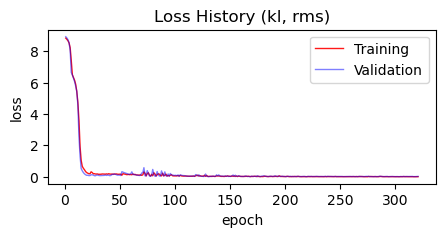

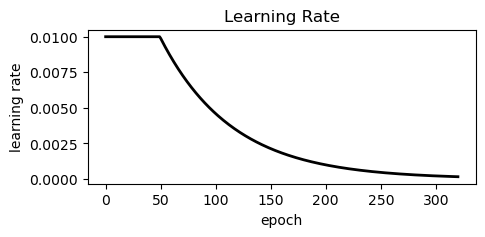

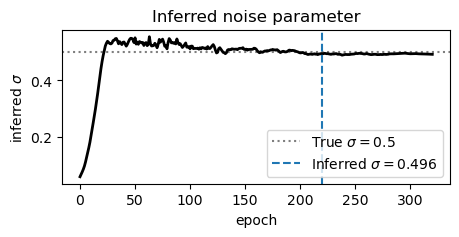

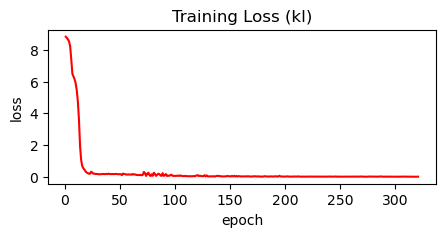

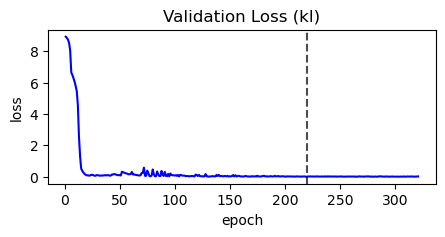

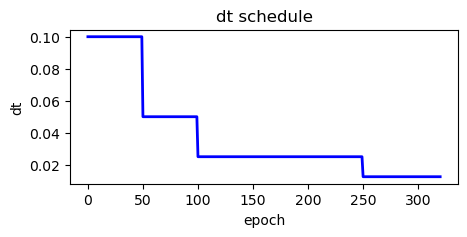

In [8]:
FIGSIZE = (5,2)

logplot = False
loss_method = logged_args['loss']
optimizer = logged_args['optimizer']

# Combined Loss History
ax = pl.plot_loss_history(
    loss_train, loss_valid, log=logplot, 
    color_train='r', color_valid='b',
    marker_train=None, marker_valid=None,
    linestyle_train='-', linestyle_valid='-',
    linewidth_train=1, linewidth_valid=1,
    alpha_train=0.9, alpha_valid=0.5,
    title=f"Loss History ({loss_method}, {optimizer})",
    figsize=FIGSIZE,
)
plt.savefig(f"{OUTDIR}/loss_hist.pdf")
if SCRIPT: plt.close()

# Learning Rate History
ax = pl.plot_learning_rate_history(
    lr_hist, log=False,
    color='k', marker=None, linestyle='-',
    figsize=FIGSIZE,
)
plt.savefig(f"{OUTDIR}/lr_hist.pdf")
if SCRIPT: plt.close()

# Noise Parameter History
ax = pl.plot_sigma_history(
    sigma_hist, log=False, sigma_true=sigma_true,
    color='k', marker=None, linestyle='-',
    figsize=FIGSIZE,
)
ax.axvline(
    idx, 0, 1,
    linestyle='--', 
    label=f"Inferred $\sigma={model.get_sigma():.3g}$"
)
ax.legend()
plt.savefig(f"{OUTDIR}/sigma_hist.pdf")
if SCRIPT: plt.close()

# Training Loss History
ax = pl.plot_training_loss_history(
    loss_train, 
    log=logplot, 
    title=f"Training Loss ({loss_method})",
    color='r', marker=None, linestyle='-',
    figsize=FIGSIZE,
)
plt.savefig(f"{OUTDIR}/loss_train_hist.pdf")
if SCRIPT: plt.close()

# Validation Loss History
ax = pl.plot_validation_loss_history(
    loss_valid, 
    log=logplot, 
    title=f"Validation Loss ({loss_method})",
    color='b', marker=None, linestyle='-',
    figsize=FIGSIZE,
    optidx=idx,
)
plt.savefig(f"{OUTDIR}/loss_valid_hist.pdf")
if SCRIPT: plt.close()

# Initial Internal Timestep History
if dt_hist is not None:
    ax = pl.plot_dt_history(
        dt_hist, 
        title=f"dt schedule",
        color='b', marker=None, linestyle='-',
        figsize=FIGSIZE,
    )
    plt.savefig(f"{OUTDIR}/dt_hist.pdf")
    if SCRIPT: plt.close()

In [9]:
# Compute the median distance between points in the training data
all_cells = []
for d in train_dset:
    x0 = d[0][1]
    all_cells.append(x0)
x1 = d[1]
all_cells.append(x1)
all_cells = np.array(all_cells)

meds = -100 * np.ones(len(all_cells))
for i, xs in enumerate(all_cells):
    dot_product = np.dot(xs, xs.T)
    # Extract the diagonal (squared norms of each point)
    squared_norms = np.diag(dot_product)
    # Compute the pairwise squared distances using the formula
    pairwise_distances = squared_norms[:, None] + squared_norms[None, :] - 2 * dot_product
    lower_elems = pairwise_distances[
        np.tril_indices(pairwise_distances.shape[0], k=-1)
    ]
    median = np.median(lower_elems)
    meds[i] = median

print("min of median pairwise distance across training points:", np.min(meds))
print("med of median pairwise distance across training points:", np.median(meds))
print("max of median pairwise distance across training points:", np.max(meds))

min of median pairwise distance across training points: 0.8998080345470214
med of median pairwise distance across training points: 1.0718710180752922
max of median pairwise distance across training points: 1.212535641927424


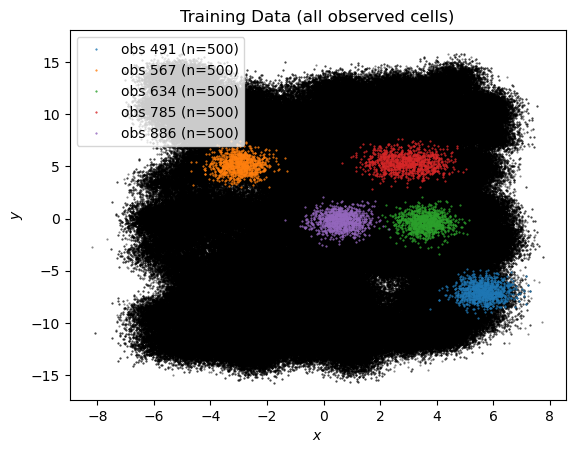

In [10]:
fig, ax = plt.subplots(1, 1)

for d in train_dset:
    x0 = d[0][1]
    x1 = d[1]
    ax.plot(x0[:,0], x0[:,1], '.k', markersize=1, alpha=0.5, rasterized=True)
    ax.plot(x1[:,0], x1[:,1], '.k', markersize=1, alpha=0.5, rasterized=True)

idxs = np.sort(rng.integers(len(train_dset), size=5))

for idx in idxs:
    x0 = train_dset[idx][0][1]
    x1 = train_dset[idx][1]
    l, = ax.plot(
        x0[:,0], x0[:,1], '.', markersize=1, alpha=1,
        label=f"obs {idx} (n={len(x0)})",
        rasterized=False,
    )
    ax.plot(
        x1[:,0], x1[:,1], '.', markersize=1, alpha=1,
        color=l.get_color(),
        rasterized=False,
    )

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Training Data (all observed cells)");
ax.legend()

plt.savefig(f"{OUTDIR}/training_data.pdf")
if SCRIPT: plt.close()

It will be helpful later to have the domain encapsulating the training data.

In [11]:
xdata = np.vstack([d[0][1] for d in train_dset] + [d[1] for d in train_dset])
XYBUFFER = 0.25
XMIN, YMIN = xdata.min(axis=0)
XMAX, YMAX = xdata.max(axis=0)

XMIN, XMAX = XMIN - (XMAX - XMIN) * XYBUFFER, XMAX + (XMAX - XMIN) * XYBUFFER
YMIN, YMAX = YMIN - (YMAX - YMIN) * XYBUFFER, YMAX + (YMAX - YMIN) * XYBUFFER
print("x range:", XMIN, XMAX)
print("y range:", YMIN, YMAX)

x range: -12.165719951051003 11.744391118304781
y range: -23.800153346143286 24.496813043377237


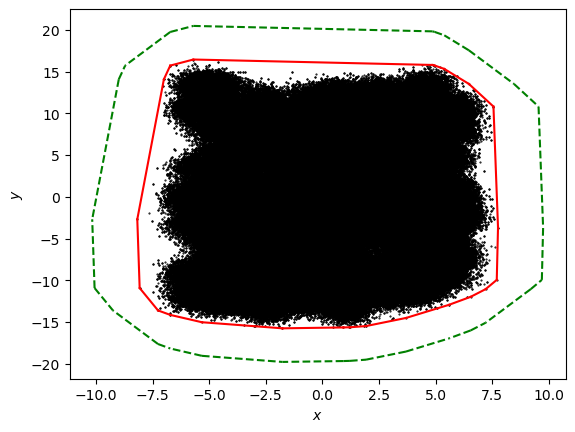

In [12]:
from scipy.spatial import ConvexHull

HULL_BUFFER = 0.5 * XYBUFFER

hull = ConvexHull(xdata)

vtx_points = xdata[hull.vertices]
hull_xrng = np.array([vtx_points[:,0].min(), vtx_points[:,0].max()])
hull_yrng = np.array([vtx_points[:,1].min(), vtx_points[:,1].max()])
hull_xshift = HULL_BUFFER * (hull_xrng[1] - hull_xrng[0])
hull_yshift = HULL_BUFFER * (hull_yrng[1] - hull_yrng[0])
vertices_shift = np.concatenate([
    vtx_points + np.array([[hull_xshift, 0]]),
    vtx_points + np.array([[-hull_xshift, 0]]),
    vtx_points + np.array([[0, hull_yshift]]),
    vtx_points + np.array([[0, -hull_yshift]]),

], axis=0)

buffered_hull = ConvexHull(vertices_shift)
HULL = vertices_shift[buffered_hull.vertices]


# Plotting
fig, ax = plt.subplots(1, 1)

ax.plot(xdata[:,0], xdata[:,1], 'k.', markersize=1, rasterized=True)
for simplex in hull.simplices:
    ax.plot(xdata[simplex, 0], xdata[simplex, 1], 'r-')

for simplex in buffered_hull.simplices:
    ax.plot(vertices_shift[simplex, 0], vertices_shift[simplex, 1], 'g--')
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

plt.savefig(f"{OUTDIR}/convex_hull.pdf")
if SCRIPT: plt.close()

In addition, we can look at the coverage of the signaling profiles.

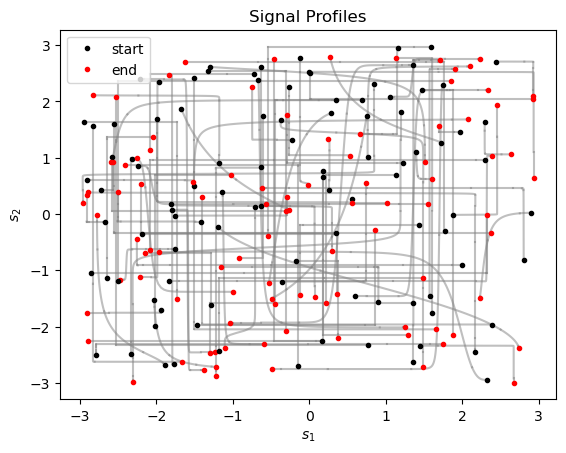

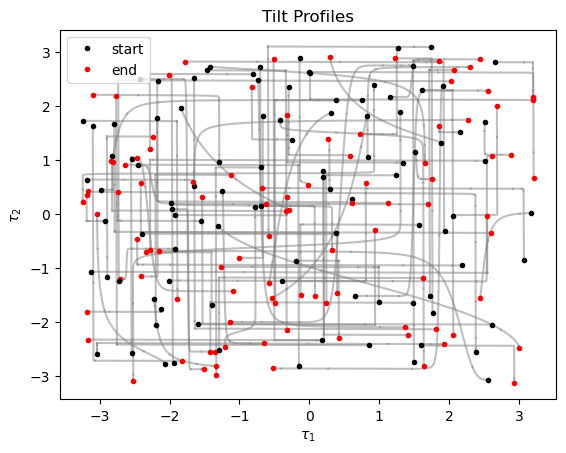

In [13]:
fig1, ax1 = plt.subplots(1, 1)
fig2, ax2 = plt.subplots(1, 1)

TSTART = np.min([d[0][0] for d in train_dset])
TFIN = np.max([d[0][2] for d in train_dset])

k = 101
sigvals_all = []
tiltvals_all = []
signal_parameters_dict = {}  # map tuple of sigparams to start and end time
for d in train_dset:
    t0 = d[0][0]
    t1 = d[0][2]
    sigparams = d[0][-1]
    key = tuple(sigparams.flatten())
    if key in signal_parameters_dict:
        current_val = signal_parameters_dict[key]
        signal_parameters_dict[key] = (min(t0, current_val[0]), 
                                       max(t1, current_val[1]))
    else:
        signal_parameters_dict[key] = (t0, t1)
    ts = np.linspace(t0, t1, k, endpoint=True)
    sigvals = jax.vmap(model.compute_signal, (0, None))(ts, sigparams)
    tiltvals = jax.vmap(model.tilt_module)(sigvals)
    ax1.plot(sigvals[:,0], sigvals[:,1], c='grey', alpha=0.5, zorder=1)
    ax2.plot(tiltvals[:,0], tiltvals[:,1], c='grey', alpha=0.5, zorder=1)
    
    if t0 == TSTART:
        p0, = ax1.plot(sigvals[0,0], sigvals[0,1], '.', c='k')
        ax2.plot(tiltvals[0,0], tiltvals[0,1], '.', c='k')
    elif t1 == TFIN:
        p1, = ax1.plot(sigvals[-1,0], sigvals[-1,1], '.', c='r')
        ax2.plot(tiltvals[-1,0], tiltvals[-1,1], '.', c='r')
    sigvals_all.append(sigvals)
    tiltvals_all.append(tiltvals)

ax1.legend([p0, p1], ["start", "end"])
ax2.legend([p0, p1], ["start", "end"])

ax1.set_title("Signal Profiles")
ax1.set_xlabel("$s_1$")
ax1.set_ylabel("$s_2$")

ax2.set_title("Tilt Profiles")
ax2.set_xlabel("$\\tau_1$")
ax2.set_ylabel("$\\tau_2$")

sigvals_all = np.vstack(sigvals_all)
tiltvals_all = np.vstack(tiltvals_all)

plt.figure(fig1)
plt.savefig(f"{OUTDIR}/signal_profile_coverage.pdf")
if SCRIPT: plt.close()

plt.figure(fig2)
plt.savefig(f"{OUTDIR}/tilt_profile_coverage.pdf")
if SCRIPT: plt.close()

In [14]:
S12BUFFER = 1.0
S1MIN, S2MIN = np.min(sigvals_all, axis=0)
S1MAX, S2MAX = np.max(sigvals_all, axis=0)
S1MIN, S1MAX = S1MIN - (S1MAX - S1MIN) * S12BUFFER, \
               S1MAX + (S1MAX - S1MIN) * S12BUFFER
S2MIN, S2MAX = S2MIN - (S2MAX - S2MIN) * S12BUFFER, \
               S2MAX + (S2MAX - S2MIN) * S12BUFFER

print("s1 range:", S1MIN, S1MAX)
print("s2 range:", S2MIN, S2MAX)

TAU12BUFFER = 1.0
TAU1MIN, TAU2MIN = np.min(tiltvals_all, axis=0)
TAU1MAX, TAU2MAX = np.max(tiltvals_all, axis=0)
TAU1MIN, TAU1MAX = TAU1MIN - (TAU1MAX - TAU1MIN) * TAU12BUFFER, \
                   TAU1MAX + (TAU1MAX - TAU1MIN) * TAU12BUFFER
TAU2MIN, TAU2MAX = TAU2MIN - (TAU2MAX - TAU2MIN) * TAU12BUFFER, \
                   TAU2MAX + (TAU2MAX - TAU2MIN) * TAU12BUFFER

print("tau1 range:", TAU1MIN, TAU1MAX)
print("tau2 range:", TAU2MIN, TAU2MAX)

s1 range: -8.858663063702537 8.831357284533961
s2 range: -8.96046217471737 8.944717980066201
tau1 range: -9.698293180578364 9.665319762399132
tau2 range: -9.330164135547143 9.305772401331701


## Comparison of true and inferred ensemble trajectories


In [15]:
key = jrandom.PRNGKey(123)

nsamps = 4
test_indices = rng.integers(0, len(test_dset), size=4)

@eqx.filter_jit
def compute_loss(model, x, y, loss_fn, key):
    t0, y0, t1, sigparams = x
    y_pred = model(t0, t1, y0, sigparams, key)
    return loss_fn(y_pred, y), y_pred

losses = np.zeros(nsamps)
x1obs_samples = []
x1sim_samples = []
iterloader = iter(test_loader)
for i in range(nsamps):
    inputs, x1obs = next(iterloader)
    inputs, x1obs = test_dset[test_indices[i]]
    t0, x0, t1, sigparams = inputs
    inputs = (jnp.array([v], dtype=jnp.float64) for v in inputs)
    x1obs = jnp.array([x1obs])
    key, subkey = jrandom.split(key, 2)
    model
    loss, x1sim = compute_loss(model, inputs, x1obs, loss_fn, subkey)
    losses[i] = loss
    x1obs_samples.append(x1obs[0])
    x1sim_samples.append(x1sim[0])

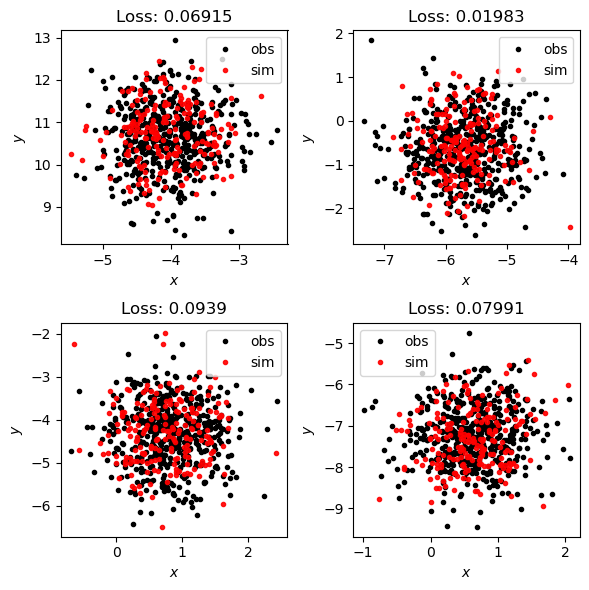

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(6,6))

for i in range(len(losses)):
    ax = axes.flatten()[i]
    ax.plot(
        x1obs_samples[i][:,0], x1obs_samples[i][:,1], 
        color='k', marker='.', linestyle='none',
        label="obs"
    )
    ax.plot(
        x1sim_samples[i][:,0], x1sim_samples[i][:,1], 
        color='r', marker='.', linestyle='none',
        label="sim",
        alpha=0.9
    )
    ax.legend()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_title(f"Loss: {losses[i]:.4g}")

plt.tight_layout()
plt.savefig(f"{OUTDIR}/sample_comparisons.pdf")
if SCRIPT: plt.close()

## Model State 
We'll illustrate the following internal model attributes:
* signal to tilt linear mapping
* noise parameter
* internal initial timestep
    

In [17]:
A = model.get_parameters()['tilt.w'][0]
b = model.get_parameters()['tilt.b'][0]
if b is None:
    b = 0.

print("A:\n", A)
print("b:", b)

def signal_to_tilt(sig):
    if sig.ndim == 1:
        return A@sig + b
    return (A@sig.T + b).T
    
def tilt_to_signal(tilt):
    if tilt.ndim == 1:
        return np.linalg.solve(A, tilt - b)
    return np.linalg.solve(A, tilt.T - b).T

A:
 [[ 1.09460701 -0.00240022]
 [-0.00375597  1.03879388]]
b: 0.0


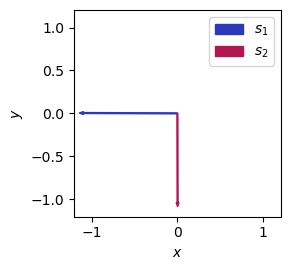

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.set_aspect('equal')

scale = np.max(np.abs(A))

ax.arrow(
    0, 0, -A[0,0], -A[1,0], 
    width=0.01*scale, 
    fc=CHIR_COLOR, ec=CHIR_COLOR,
    label="$s_1$"
)

ax.arrow(
    0, 0, -A[0,1], -A[1,1], 
    width=0.01*scale, 
    fc=FGF_COLOR, ec=FGF_COLOR,
    label="$s_2$"
)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_xlim([-scale*1.1, scale*1.1])
ax.set_ylim([-scale*1.1, scale*1.1])

ax.legend();

plt.tight_layout()
plt.savefig(f"{OUTDIR}/signal_direction.pdf")
if SCRIPT: plt.close()

In [19]:
print("Model's inferred noise scale:", model.get_sigma())
print("Model's internal initial timestep:", model.get_dt0())

Model's inferred noise scale: 0.4956927280404412
Model's internal initial timestep: 0.025


In [20]:
# Inferred model parameters
print("Model inferred a:", model.phi_module.a)
print("Model inferred b:", model.phi_module.b)


Model inferred a: 0.27395889839671095
Model inferred b: 0.11446955921585629


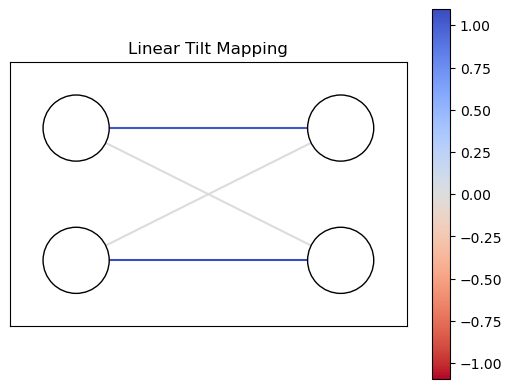

In [21]:
ax = pl.plot_neural_network(
    model.get_parameters()['tilt.w'],
    model.get_parameters()['tilt.b'],
    normalization=None,
    colormap='coolwarm_r',
    highlight_above=0,
    alpha=1,
);
ax.set_title("Linear Tilt Mapping");
ax.set_xlim(-0.25, 1.25)

plt.savefig(f"{OUTDIR}/tilt_map_schematic.pdf")
if SCRIPT: plt.close()

### Landscape plots

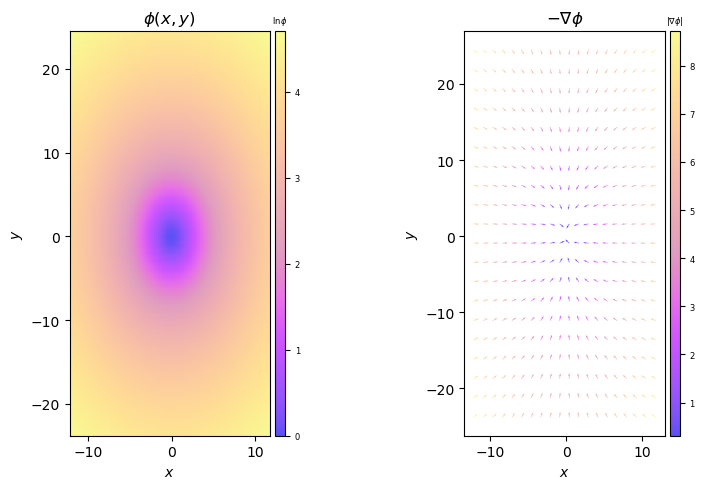

<Figure size 640x480 with 0 Axes>

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

pl.plot_phi(
    model,
    res=RESOLUTION,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    equal_axes=True,
    cbar_title="$\ln\phi$",
    ax=axes[0],
    show=True,
)

pl.plot_f(
    model,
    res=20,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    equal_axes=True,
    title="$-\\nabla\phi$",
    cbar_title="$|\\nabla\phi|$",
    ax=axes[1],
    show=True,
)

if not SCRIPT: plt.show()
plt.tight_layout()

plt.savefig(f"{OUTDIR}/landscape_and_field.pdf")
if SCRIPT: plt.close()

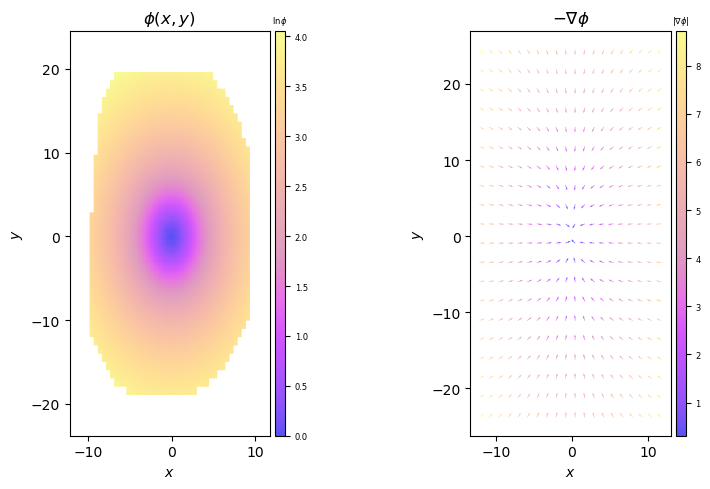

<Figure size 640x480 with 0 Axes>

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

try:
    pl.plot_phi(
        model,
        res=RESOLUTION,
        xrange=[XMIN, XMAX],
        yrange=[YMIN, YMAX],
        equal_axes=True,
        cbar_title="$\ln\phi$",
        hull=HULL,
        ax=axes[0],
        show=True,
    )

    pl.plot_f(
        model,
        res=20,
        xrange=[XMIN, XMAX],
        yrange=[YMIN, YMAX],
        equal_axes=True,
        title="$-\\nabla\phi$",
        cbar_title="$|\\nabla\phi|$",
        ax=axes[1],
        show=True,
    )
except ValueError as e:
    print("Encountered ValueError:")
    raise ValueError(e)

if not SCRIPT: plt.show()
plt.tight_layout()

plt.savefig(f"{OUTDIR}/landscape_and_field_hulled.pdf")
if SCRIPT: 
    plt.close()

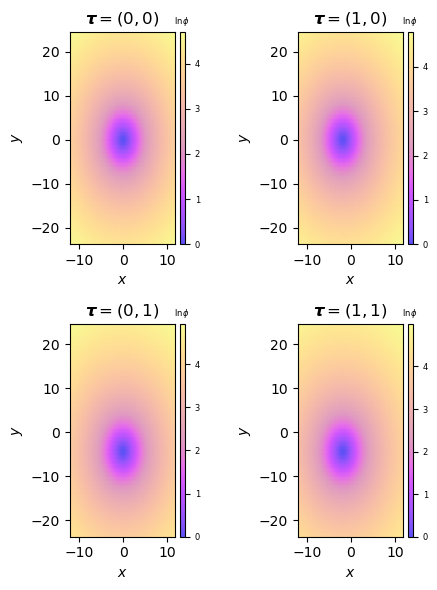

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(6,6))

pl.plot_phi(
    model,
    res=RESOLUTION,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    equal_axes=True,
    title="$\\boldsymbol{\\tau}=(0,0)$",
    cbar_title="$\ln\phi$",
    ax=axes[0,0],
    show=True,
)

pl.plot_phi(
    model,
    res=RESOLUTION,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    tilt=[1, 0],
    equal_axes=True,
    title="$\\boldsymbol{\\tau}=(1,0)$",
    cbar_title="$\ln\phi$",
    ax=axes[0,1],
    show=True,
)

pl.plot_phi(
    model,
    res=RESOLUTION,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    tilt=[0, 1],
    equal_axes=True,
    title="$\\boldsymbol{\\tau}=(0,1)$",
    cbar_title="$\ln\phi$",
    ax=axes[1,0],
    show=True,
)

pl.plot_phi(
    model,
    res=RESOLUTION,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    tilt=[1, 1],
    equal_axes=True,
    title="$\\boldsymbol{\\tau}=(1,1)$",
    cbar_title="$\ln\phi$",
    ax=axes[1,1],
    show=True,
)

plt.tight_layout()
plt.savefig(f"{OUTDIR}/landscape_4_tilts.pdf")
if SCRIPT: plt.close()

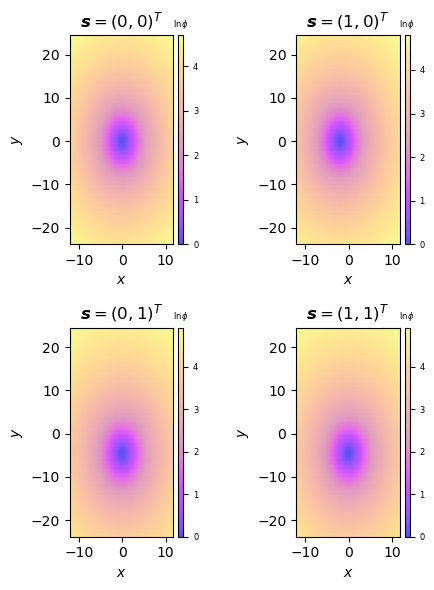

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(6,6))

pl.plot_phi(
    model,
    res=RESOLUTION,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    equal_axes=True,
    title="$\\boldsymbol{s}=(0,0)^T$",
    cbar_title="$\ln\phi$",
    ax=axes[0,0],
    show=True,
)

pl.plot_phi(
    model,
    signal=[1, 0],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=RESOLUTION,
    equal_axes=True,
    title="$\\boldsymbol{s}=(1,0)^T$",
    cbar_title="$\ln\phi$",
    ax=axes[0,1],
    show=True,
)

pl.plot_phi(
    model,
    signal=[0, 1],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=RESOLUTION,
    equal_axes=True,
    title="$\\boldsymbol{s}=(0,1)^T$",
    cbar_title="$\ln\phi$",
    ax=axes[1,0],
    show=True,
)

pl.plot_phi(
    model,
    signal=[0, 1],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=RESOLUTION,
    equal_axes=True,
    title="$\\boldsymbol{s}=(1,1)^T$",
    cbar_title="$\ln\phi$",
    ax=axes[1,1],
    show=True,
)

plt.tight_layout();
plt.savefig(f"{OUTDIR}/landscape_4_signals.pdf")
if SCRIPT: plt.close()

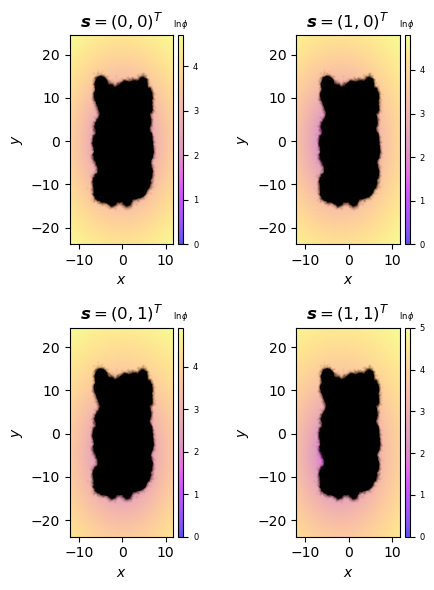

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(6,6))

pl.plot_phi(
    model,
    res=RESOLUTION,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    equal_axes=True,
    title="$\\boldsymbol{s}=(0,0)^T$",
    cbar_title="$\ln\phi$",
    ax=axes[0,0],
    show=True,
)

pl.plot_phi(
    model,
    signal=[1, 0],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=RESOLUTION,
    equal_axes=True,
    title="$\\boldsymbol{s}=(1,0)^T$",
    cbar_title="$\ln\phi$",
    ax=axes[0,1],
    show=True,
)

pl.plot_phi(
    model,
    signal=[0, 1],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=RESOLUTION,
    equal_axes=True,
    title="$\\boldsymbol{s}=(0,1)^T$",
    cbar_title="$\ln\phi$",
    ax=axes[1,0],
    show=True,
)

for ax in axes.flatten():
    ax.plot(
        xdata[:,0], xdata[:,1], 'k.', 
        markersize=1, 
        alpha=0.025,
        rasterized=True,
    )

pl.plot_phi(
    model,
    signal=[1, 1],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=RESOLUTION,
    equal_axes=True,
    title="$\\boldsymbol{s}=(1,1)^T$",
    cbar_title="$\ln\phi$",
    ax=axes[1,1],
    show=True,
)

plt.tight_layout();
plt.savefig(f"{OUTDIR}/landscape_4_signals_with_data.pdf")
if SCRIPT: plt.close()

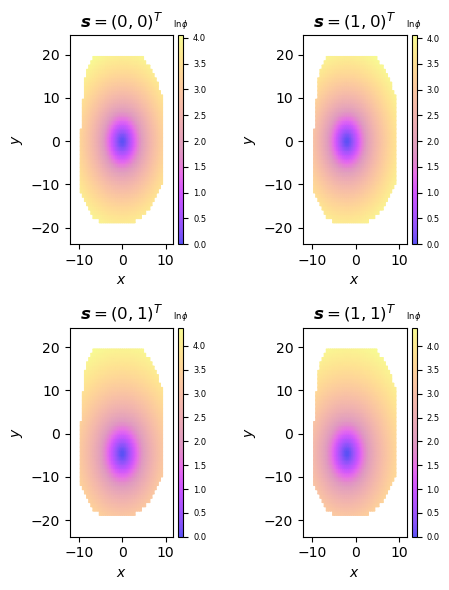

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(6,6))

pl.plot_phi(
    model,
    res=RESOLUTION,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    equal_axes=True,
    title="$\\boldsymbol{s}=(0,0)^T$",
    cbar_title="$\ln\phi$",
    hull=HULL,
    ax=axes[0,0],
    show=True,
)

pl.plot_phi(
    model,
    signal=[1, 0],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=RESOLUTION,
    equal_axes=True,
    title="$\\boldsymbol{s}=(1,0)^T$",
    cbar_title="$\ln\phi$",
    hull=HULL,
    ax=axes[0,1],
    show=True,
)

pl.plot_phi(
    model,
    signal=[0, 1],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=RESOLUTION,
    equal_axes=True,
    title="$\\boldsymbol{s}=(0,1)^T$",
    cbar_title="$\ln\phi$",
    hull=HULL,
    ax=axes[1,0],
    show=True,
)

pl.plot_phi(
    model,
    signal=[1, 1],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=RESOLUTION,
    equal_axes=True,
    title="$\\boldsymbol{s}=(1,1)^T$",
    cbar_title="$\ln\phi$",
    hull=HULL,
    ax=axes[1,1],
    show=True,
)

plt.tight_layout();
plt.savefig(f"{OUTDIR}/landscape_4_signals_hulled.pdf")
if SCRIPT: plt.close()

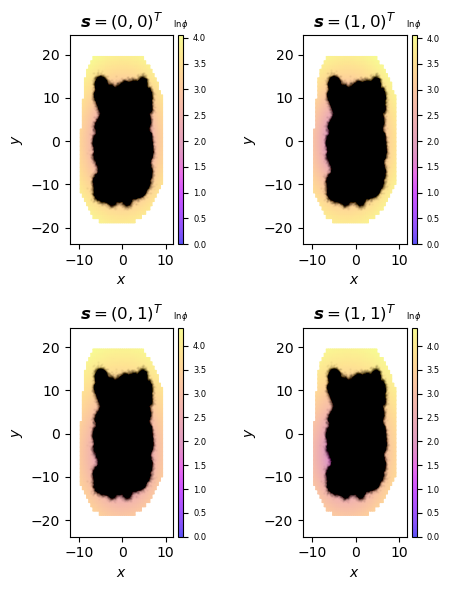

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(6,6))

pl.plot_phi(
    model,
    res=RESOLUTION,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    equal_axes=True,
    title="$\\boldsymbol{s}=(0,0)^T$",
    cbar_title="$\ln\phi$",
    hull=HULL,
    ax=axes[0,0],
    show=True,
)

pl.plot_phi(
    model,
    signal=[1, 0],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=RESOLUTION,
    equal_axes=True,
    title="$\\boldsymbol{s}=(1,0)^T$",
    cbar_title="$\ln\phi$",
    hull=HULL,
    ax=axes[0,1],
    show=True,
)

pl.plot_phi(
    model,
    signal=[0, 1],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=RESOLUTION,
    equal_axes=True,
    title="$\\boldsymbol{s}=(0,1)^T$",
    cbar_title="$\ln\phi$",
    hull=HULL,
    ax=axes[1,0],
    show=True,
)

pl.plot_phi(
    model,
    signal=[1, 1],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=RESOLUTION,
    equal_axes=True,
    title="$\\boldsymbol{s}=(1,1)^T$",
    cbar_title="$\ln\phi$",
    hull=HULL,
    ax=axes[1,1],
    show=True,
)

for ax in axes.flatten():
    ax.plot(
        xdata[:,0], xdata[:,1], 'k.', 
        markersize=1, 
        alpha=0.025,
        rasterized=True,
    )

plt.tight_layout();
plt.savefig(f"{OUTDIR}/landscape_4_signals_hulled_with_data.pdf")
if SCRIPT: plt.close()

## Simulation

In [29]:
key = jrandom.PRNGKey(rng.integers(2**32))

idx = rng.integers(len(train_dset))
sigparams = train_dset[idx][0][-1]
_, tfin = signal_parameters_dict[tuple(sigparams.flatten())]
sim_sigparams = sigparams  # store to maintain for animation, below.

ncells = model.get_ncells()
dtsave1 = tfin/NFRAMES
dtsave2 = tfin/10

# Initial condition
key, subkey = jrandom.split(key, 2)
# x0 = jrandom.normal(subkey, [ncells, 2])
x0 = train_dset[idx][0][1]

# Simulate particles in the landscape
key, subkey = jrandom.split(key, 2)
ts_all, xs_all, sigs_all, ps_all = model.run_landscape_simulation(
    x0, tfin, [dtsave1, dtsave2], sigparams, subkey
)

sim_ts, sim_ts_saved = ts_all
sim_xs, sim_xs_saved = xs_all
sim_sigs, sim_sigs_saved = sigs_all
sim_ps, sim_ps_saved = ps_all

In [30]:
sigparams

array([[45.84157572, -2.0303833 , -1.22435694,  0.09389266],
       [31.43628516, -1.51427417, -2.7155766 ,  0.09087023]])

In [31]:
from plnn.vectorfields import find_minima_along_tilt_trajectory
from plnn.vectorfields import check_minima_trajectories_for_bifurcations

minima = find_minima_along_tilt_trajectory(
    model, sim_ps,
    ndivisions=20,
    tol=1e-3,
    x0_range=[[XMIN, XMAX],[YMIN,YMAX]],
    method="BFGS",
    opt_tol=1e-5,
)

bifs, bif_idxs, bif_tilts, bif_mins = check_minima_trajectories_for_bifurcations(
    sim_ps, minima
)

Identified 0 potential bifurcation points...
Starting points for potential bifurcations:
 []


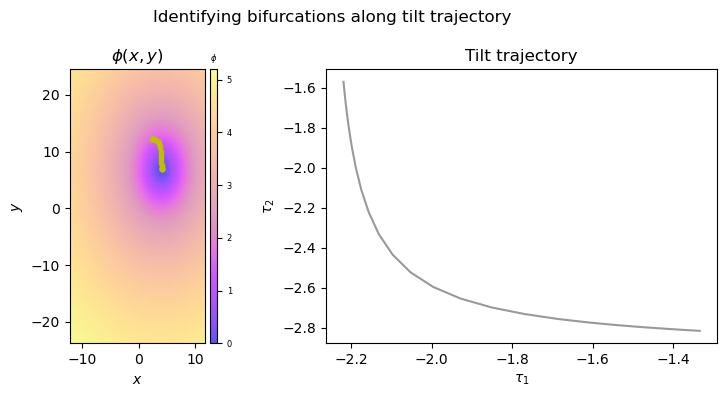

In [32]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

print(f"Identified {len(bif_idxs)} potential bifurcation points...")
for i in range(len(bif_idxs)):
    tau0, tau1 = bif_tilts[i]
    mins0, mins1 = bif_mins[i]
    print(f"At time t={sim_ts[bif_idxs[i]]}:")
    print(f"\ttau=({', '.join([f'{x:.3g}' for x in tau0])})")
    print(f"\tmins0:")
    for m in mins0:
        print(f"\t\t{m}")
    print(f"\tmins1:")
    for m in mins1:
        print(f"\t\t{m}")
print(f"Starting points for potential bifurcations:\n", bifs)

pl.plot_phi(
    model,
    tilt=sim_ps[0],
    res=RESOLUTION,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    equal_axes=True,
    ax=ax1,
    show=True,
)

for i in range(len(minima)):
    ax1.plot(minima[i][:,0], minima[i][:,1], '.y');

ax2.plot(sim_ps[:,0], sim_ps[:,1], '-', color='grey', alpha=0.8)

for bifmin, tilt in zip(bifs, bif_tilts):
    l, = ax1.plot(*bifmin, '*', alpha=0.7)
    color = l.get_color()
    ax2.plot(*tilt[0], '*', c=color)
    ax2.plot(*tilt[1], '*', c=color)

ax2.set_xlabel(f"$\\tau_1$")
ax2.set_ylabel(f"$\\tau_2$")
ax2.set_title(f"Tilt trajectory")

fig.suptitle("Identifying bifurcations along tilt trajectory")

plt.tight_layout()

plt.savefig(f"{OUTDIR}/param_profile_bif_finding.pdf")
if SCRIPT: plt.close()

In [33]:
from cont.plnn_bifurcations import get_plnn_bifurcation_curves

landscape_tex = "$\phi$"

bifcurves, bifcolors = get_plnn_bifurcation_curves(
    model, 
    num_starts=50,
    p1lims=[TAU1MIN, TAU1MAX],
    p2lims=[TAU2MIN, TAU2MAX],
    xstarts=[[x, None] for x in bifs],
    xlims=[XMIN, XMAX],
    ylims=[YMIN, YMAX],
    color=None,
    maxiter=10000,
    ds=1e-3,
    min_ds=1e-8,
    max_ds=1e-2,
    max_delta_p=1e-2,
    rho=1e-1,
    seed=rng.integers(2**32),
    verbosity=0,
)

# Filter out singleton bifurcation curves and remove initial estimate point
keepidxs = [i for i in range(len(bifcurves)) if len(bifcurves[i]) > 1]
bifcurves = [bc[1:] for bc in bifcurves if len(bc) > 1]
bifcolors = [bifcolors[i] for i in keepidxs]


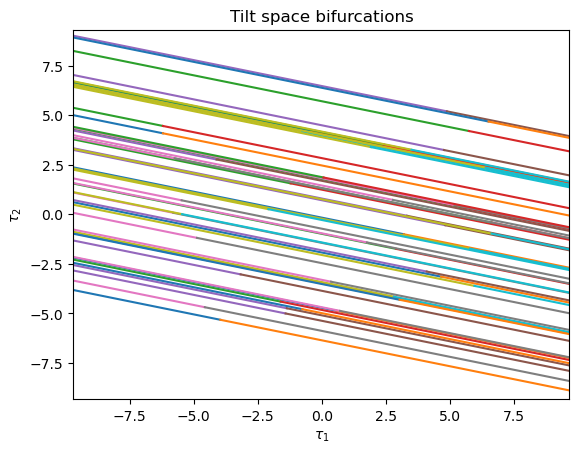

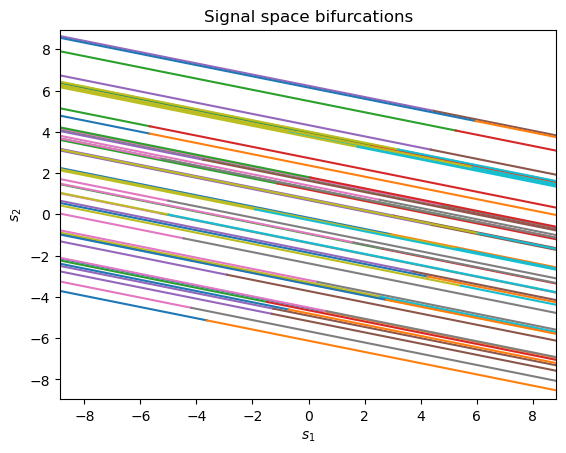

In [34]:
fig, ax = plt.subplots(1, 1)
for i in range(len(bifcurves)):
    curve = bifcurves[i]
    color = bifcolors[i]
    ax.plot(curve[:,0], curve[:,1], color=color, linestyle='-')
ax.set_xlabel("$\\tau_1$")
ax.set_ylabel("$\\tau_2$");
ax.set_title("Tilt space bifurcations");
ax.set_xlim(TAU1MIN, TAU1MAX)
ax.set_ylim(TAU2MIN, TAU2MAX)

plt.savefig(f"{OUTDIR}/tilt_space_bifs_init_search.pdf")
if SCRIPT: plt.close()


fig, ax = plt.subplots(1, 1)
for i in range(len(bifcurves)):
    curve = bifcurves[i]
    curve = tilt_to_signal(curve)
    color = bifcolors[i]
    ax.plot(curve[:,0], curve[:,1], color=color, linestyle='-')
ax.set_xlabel("$s_1$")
ax.set_ylabel("$s_2$");
ax.set_title("Signal space bifurcations");
ax.set_xlim(S1MIN, S1MAX)
ax.set_ylim(S2MIN, S2MAX)

plt.savefig(f"{OUTDIR}/signal_space_bifs_init_search.pdf")
if SCRIPT: plt.close()

In [35]:
num_ts = 10
key_list = []
x_bif_points_traj_list = []
tilt_bif_points_list = []
for key in tqdm.tqdm(signal_parameters_dict):
    sigparams = np.array(key).reshape([2,-1])
    t0, t1 = signal_parameters_dict[key]
    assert sigparams.shape == (2,4), "Wrong shape for sigparams"
    ts_arr = np.linspace(t0, t1, num_ts, endpoint=True)
    sigtraj = jax.vmap(model.compute_signal, (0, None))(ts_arr, sigparams)
    tilttraj = signal_to_tilt(sigtraj)
    
    minima_along_traj = find_minima_along_tilt_trajectory(
        model, tilttraj,
        ndivisions=5,
        n=4,
        tol=1e-3,
        x0_range=[[XMIN, XMAX],[YMIN,YMAX]],
        method="BFGS",
        opt_tol=1e-5,
    )

    bifs, bif_idxs, bif_tilts, bif_mins = check_minima_trajectories_for_bifurcations(
        tilttraj, minima_along_traj
    )
    key_list.append(key)
    x_bif_points_traj_list.append(bifs)
    tilt_bif_points_list.append(bif_tilts)

# Pool bifurcation points
bifs_all = [b for b in x_bif_points_traj_list if len(b) > 0]
if bifs_all:
    bifs_all = np.vstack(bifs_all)

100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


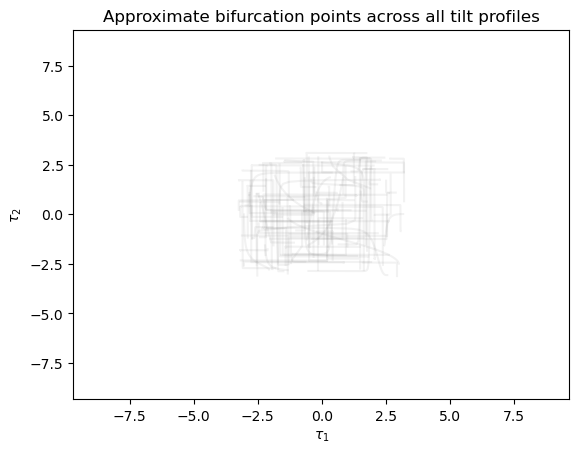

In [36]:
fig, ax = plt.subplots(1, 1)

num_ts = 101
for key, bifs_set in zip(key_list, tilt_bif_points_list):
    t0, t1 = signal_parameters_dict[key]
    ts = np.linspace(t0, t1, num_ts, endpoint=True)
    sigparams = np.array(key).reshape([2,-1])
    sigvals = jax.vmap(model.compute_signal, (0, None))(ts, sigparams)
    tiltvals = jax.vmap(model.tilt_module)(sigvals)
    alpha = 0.5 if len(bifs_set) > 0 else 0.1
    ax.plot(tiltvals[:,0], tiltvals[:,1], c='grey', alpha=alpha, zorder=1)
    for tilt0, tilt1 in bifs_set:
        ax.plot(*tilt0, '.', color='r')
    
ax.set_xlabel(f"$\\tau_1$")
ax.set_ylabel(f"$\\tau_2$")
ax.set_title(f"Approximate bifurcation points across all tilt profiles");
ax.set_xlim(TAU1MIN, TAU1MAX)
ax.set_ylim(TAU2MIN, TAU2MAX)

plt.savefig(f"{OUTDIR}/pooled_tilt_profiles_approx_bifpoints.pdf")
if SCRIPT: plt.close()

In [37]:
landscape_tex = "$\phi$"

n_additional_starts = 150

bifcurves, bifcolors, aux_info = get_plnn_bifurcation_curves(
    model, 
    num_starts=len(bifs_all) + n_additional_starts,
    p1lims=[TAU1MIN, TAU1MAX],
    p2lims=[TAU2MIN, TAU2MAX],
    xstarts=[[x, None] for x in bifs_all],
    xlims=[XMIN, XMAX],
    ylims=[YMIN, YMAX],
    color=None,
    maxiter=10000,
    ds=1e-3,
    min_ds=1e-8,
    max_ds=1e-2,
    max_delta_p=1e-2,
    rho=1e-1,
    return_aux_info=True,
    seed=rng.integers(2**32),
    verbosity=0,
)

# Filter out singleton bifurcation curves and remove initial estimate point
keepidxs = [i for i in range(len(bifcurves)) if len(bifcurves[i]) > 1]
bifcurves_plt = [bc[1:] for bc in bifcurves if len(bc) > 1]
bifcolors_plt = [bifcolors[i] for i in keepidxs]


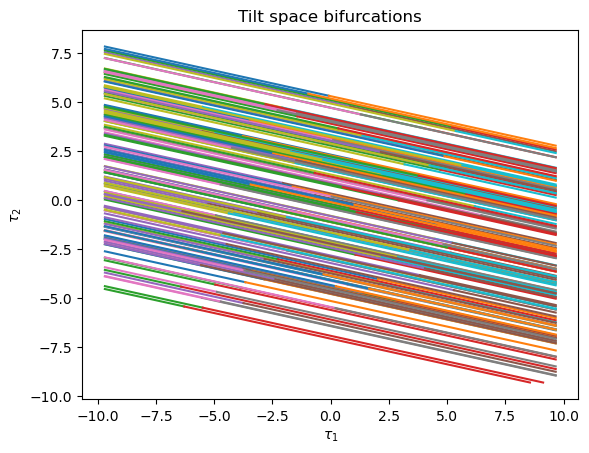

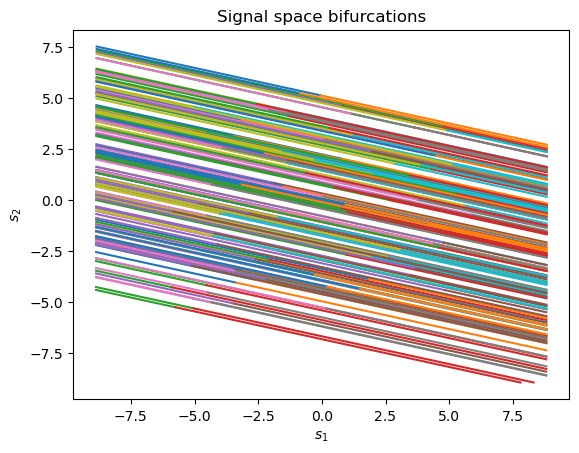

In [38]:
fig, ax = plt.subplots(1, 1)

for i in range(len(bifcurves_plt)):
    curve = bifcurves_plt[i]
    color = bifcolors_plt[i]
    ax.plot(curve[:,0], curve[:,1], color=color, linestyle='-', alpha=1)
ax.set_xlabel("$\\tau_1$")
ax.set_ylabel("$\\tau_2$");
ax.set_title("Tilt space bifurcations");

plt.savefig(f"{OUTDIR}/tilt_space_bifs.pdf")
if SCRIPT: plt.close()


fig, ax = plt.subplots(1, 1)

for i in range(len(bifcurves_plt)):
    curve = bifcurves_plt[i]
    curve = tilt_to_signal(curve)
    color = bifcolors_plt[i]
    ax.plot(curve[:,0], curve[:,1], color=color, linestyle='-', alpha=1)
ax.set_xlabel("$s_1$")
ax.set_ylabel("$s_2$");
ax.set_title("Signal space bifurcations");

plt.savefig(f"{OUTDIR}/signal_space_bifs.pdf")
if SCRIPT: plt.close()

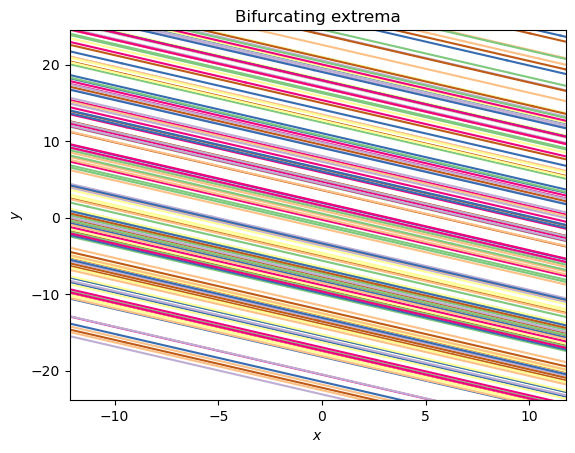

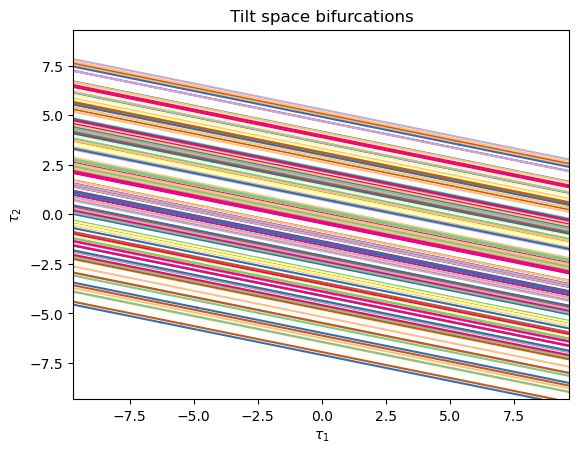

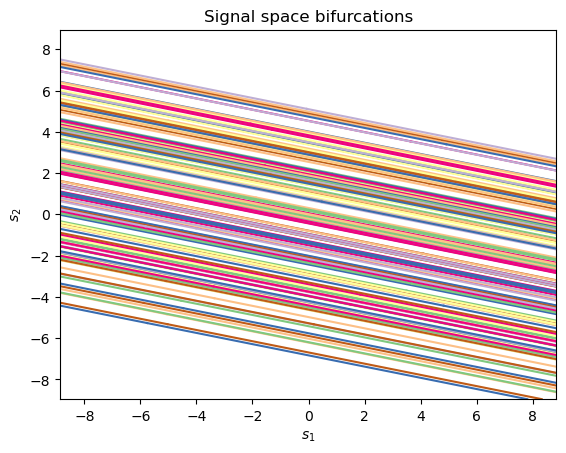

In [39]:
fig1, ax1 = plt.subplots(1, 1)
fig2, ax2 = plt.subplots(1, 1)
fig3, ax3 = plt.subplots(1, 1)

for ax in [ax1, ax2, ax3]:
    ax.set_prop_cycle(color=plt.get_cmap('Accent').colors[:-1])

for i in range(len(aux_info)):
    info = aux_info[i]
    if 'xs_path_fwd' in info:
        xpath_fwd = info['xs_path_fwd'][1:]
        xpath_rev = info['xs_path_rev'][1:]
        ppath_fwd = info['ps_path_fwd'][1:]
        ppath_rev = info['ps_path_rev'][1:]
        spath_fwd = tilt_to_signal(ppath_fwd)
        spath_rev = tilt_to_signal(ppath_rev)
        l1, = ax1.plot(
            xpath_fwd[:,0], xpath_fwd[:,1], 
            color=None, linestyle='-', alpha=1,
        )
        color = l1.get_color()
        ax1.plot(
            xpath_rev[:,0], xpath_rev[:,1], 
            color=color, linestyle='-', alpha=1
        )
        ax2.plot(
            ppath_fwd[:,0], ppath_fwd[:,1], 
            color=color, linestyle='-', alpha=1
        )
        ax2.plot(
            ppath_rev[:,0], ppath_rev[:,1], 
            color=color, linestyle='-', alpha=1
        )
        ax3.plot(
            spath_fwd[:,0], spath_fwd[:,1], 
            color=color, linestyle='-', alpha=1
        )
        ax3.plot(
            spath_rev[:,0], spath_rev[:,1], 
            color=color, linestyle='-', alpha=1
        )
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y$");
ax1.set_title("Bifurcating extrema");
ax1.set_xlim(XMIN, XMAX)
ax1.set_ylim(YMIN, YMAX)

ax2.set_xlabel("$\\tau_1$")
ax2.set_ylabel("$\\tau_2$")
ax2.set_title("Tilt space bifurcations");
ax2.set_xlim(TAU1MIN, TAU1MAX)
ax2.set_ylim(TAU2MIN, TAU2MAX)

ax3.set_xlabel("$s_1$")
ax3.set_ylabel("$s_2$")
ax3.set_title("Signal space bifurcations");
ax3.set_xlim(S1MIN, S1MAX)
ax3.set_ylim(S2MIN, S2MAX)

plt.figure(fig1)
plt.savefig(f"{OUTDIR}/bifdiag_extrema.pdf")
if SCRIPT: plt.close()

plt.figure(fig2)
plt.savefig(f"{OUTDIR}/bifdiag_tilts.pdf")
if SCRIPT: plt.close()

plt.figure(fig3)
plt.savefig(f"{OUTDIR}/bifdiag_signals.pdf")
if SCRIPT: plt.close()

# Simulation Animation

In [40]:
duration = 10
dpi = 200
grid_size = 1

animator = PLNNSimulationAnimator(
    model, sim_sigparams,
    sim_ts, sim_xs, sim_sigs, sim_ps, 
    sim_ts_saved, sim_xs_saved, sim_sigs_saved, sim_ps_saved, 
    xlims=[XMIN, XMAX], ylims=[YMIN, YMAX],
    p0lims=[TAU1MIN, TAU1MAX],
    p1lims=[TAU2MIN, TAU2MAX],
    minima=minima,
    bifcurves=bifcurves,
    bifcolors=bifcolors,
    grad_func=lambda x, y, p: -model.grad_phi_with_signal(
        None, np.array([x, y]).T, p).T,
    view_init=(45, 30),
    sig_names=['$s_1$', '$s_2$'],
    param_names=['$\\tau_1$', '$\\tau_2$'],
    note_string=f"Model path: {model_fpath}"
)

ani = animator.animate(
    duration=duration,
    dpi=dpi,
    grid_width=grid_size,
    grid_height=grid_size,
)
plt.close()

Generating movie...
Finished in 0.835 seconds.


In [41]:
if not SCRIPT:
    display(HTML(ani.to_html5_video()))

In [42]:
if SAVE_ANIMATION:
    ani = animator.animate(
        duration=duration,
        dpi=dpi,
        grid_width=grid_size,
        grid_height=grid_size,
        savepath=f"{OUTDIR}/animation_demo",
        saveas='mp4',
    )